# 因果の効果が小さい場合のベイズファクター
このノートブックでは, 回帰係数が一様分布U(-1.5, 1.5)から生成される場合に, ベイズファクターによって因果の効果が小さい場合を判断できるかどうかを確認します. 

In [1]:
%matplotlib inline
%autosave 0
import sys, os
sys.path.insert(0, os.path.expanduser('~/work/tmp/20160915-bmlingam/bmlingam'))

from copy import deepcopy
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from bmlingam import do_mcmc_bmlingam, InferParams, MCMCParams, save_pklz, load_pklz, define_hparam_searchspace, find_best_model
from bmlingam.utils.gendata import GenDataParams, gen_artificial_data

Autosave disabled


## 実験条件
実験条件は以下の通りです. 

* 人工データパラメータ

    * サンプル数 (`n_samples`): `[100]`
    * 総ノイズスケール: $c=0.5, 1.0$. 
    * 交絡因子のスケール: $c/\sqrt{Q}$
    * データ観測ノイズ分布 (`data_noise_type`): `['laplace', 'uniform']`
    * 交絡因子数 (`n_confs` or $Q$): `[10]`
    * 観測データノイズスケール: 3に固定
    * 回帰係数の分布 `uniform(-1.5, 1.5)`

* 推定ハイパーパラメータ

    * 交絡因子相関係数 (`L_cov_21s`): `[[-.9, -.7, -.5, -.3, 0, .3, .5, .7, .9]]`
    * モデル観測ノイズ分布 (`model_noise_type`): `['gg']`

In [2]:
conds = [
        {
            'totalnoise': totalnoise, 
            'L_cov_21s': L_cov_21s, 
            'n_samples': n_samples, 
            'n_confs': n_confs, 
            'data_noise_type': data_noise_type, 
            'model_noise_type': model_noise_type, 
            'b21_dist': b21_dist
        }
        for totalnoise in [0.5, 1.0]
        for L_cov_21s in [[-.9, -.7, -.5, -.3, 0, .3, .5, .7, .9]]
        for n_samples in [100]
        for n_confs in [10] # [1, 3, 5, 10]
        for data_noise_type in ['laplace', 'uniform']
        for model_noise_type in ['gg']
        for b21_dist in ['uniform(-1.5, 1.5)']
    ]

print('{} conditions'.format(len(conds)))

4 conditions


### 人工データの生成
実験条件に基づいて人工データを生成する関数を定義します. 

In [3]:
def gen_artificial_data_given_cond(ix_trial, cond):
    # 実験条件に基づく人工データ生成パラメータの設定
    n_confs = cond['n_confs']
    gen_data_params = deepcopy(gen_data_params_default)
    gen_data_params.n_samples = cond['n_samples']
    gen_data_params.conf_dist = [['all'] for _ in range(n_confs)]
    gen_data_params.e1_dist = [cond['data_noise_type']]
    gen_data_params.e2_dist = [cond['data_noise_type']]
    gen_data_params.b21_dist = cond['b21_dist']

    noise_scale = cond['totalnoise'] / np.sqrt(n_confs)
    gen_data_params.f1_coef = [noise_scale for _ in range(n_confs)]
    gen_data_params.f2_coef = [noise_scale for _ in range(n_confs)]

    # 人工データ生成
    gen_data_params.seed = ix_trial
    data = gen_artificial_data(gen_data_params)
    
    return data

# 人工データ生成パラメータの基準値
gen_data_params_default = GenDataParams(
    n_samples=100, 
    b21_dist='r2intervals', 
    mu1_dist='randn', 
    mu2_dist='randn', 
    f1_scale=1.0, 
    f2_scale=1.0, 
    f1_coef=['r2intervals', 'r2intervals', 'r2intervals'], 
    f2_coef=['r2intervals', 'r2intervals', 'r2intervals'], 
    conf_dist=[['all'], ['all'], ['all']], 
    e1_std=3.0, 
    e2_std=3.0, 
    e1_dist=['laplace'], 
    e2_dist=['laplace'],
    seed=0
)

実行例です. 

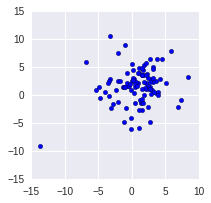

In [4]:
data = gen_artificial_data_given_cond(0, conds[0])
xs = data['xs']
plt.figure(figsize=(3, 3))
plt.scatter(xs[:, 0], xs[:, 1])

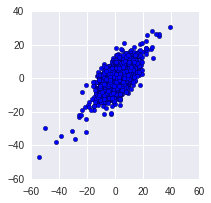

In [5]:
data = gen_artificial_data_given_cond(0, 
    {
        'totalnoise': 3 * np.sqrt(1), 
        'n_samples': 10000, 
        'n_confs': 1, 
        'data_noise_type': 'laplace',
        'b21_dist': 'uniform(-1.5, 1.5)'
    }
)
xs = data['xs']
plt.figure(figsize=(3, 3))
plt.scatter(xs[:, 0], xs[:, 1])

### トライアルの定義
トライアルとは, 生成された1つの人工データに対する因果推論と精度評価の処理を指します. 

一つの実験条件に対し, トライアルを100回実行します. 

In [6]:
n_trials_per_cond = 100

### 実験条件パラメータの基準値

In [7]:
# 因果推論パラメータ
infer_params = InferParams(
    seed=0, 
    standardize=True, 
    subtract_mu_reg=False, 
    fix_mu_zero=True, 
    prior_var_mu='auto', 
    prior_scale='uniform', 
    max_c=1.0, 
    n_mc_samples=10000, 
    dist_noise='laplace', 
    df_indvdl=8.0, 
    prior_indvdls=['t'], 
    cs=[0.4, 0.6, 0.8],
    scale_coeff=2. / 3., 
    L_cov_21s=[-0.8, -0.6, -0.4, 0.4, 0.6, 0.8], 
    betas_indvdl=None, # [0.25, 0.5, 0.75, 1.], 
    betas_noise=[0.25, 0.5, 1.0, 3.0], 
    causalities=[[1, 2], [2, 1]], 
    sampling_mode='cache_mp4'
)

# 回帰係数推定パラメータ
mcmc_params = MCMCParams(
    n_burn=1000, 
    n_mcmc_samples=1000
)

## プログラム

### トライアル識別子の生成
以下の情報からトライアルに対する識別子を生成します. 

* トライアルインデックス (`ix_trial`)
* サンプル数 (`n_samples`)
* 交絡因子数 (`n_confs`)
* 人工データ観測ノイズの種類 (`data_noise_type`)
* 予測モデル観測ノイズの種類 (`model_noise_type`)
* 交絡因子相関係数 (`L_cov_21s`)
* 総ノイズスケール (`totalnoise`)
* 回帰係数分布 (`b21_dist`)

トライアル識別子は推定結果をデータフレームに格納するときに使用されます. 

In [8]:
def make_id(ix_trial, n_samples, n_confs, data_noise_type, model_noise_type, L_cov_21s, totalnoise, b21_dist):
    L_cov_21s_ = ' '.join([str(v) for v in L_cov_21s])
    
    return hashlib.md5(
        str((L_cov_21s_, ix_trial, n_samples, n_confs, data_noise_type, model_noise_type, totalnoise, b21_dist.replace(' ', ''))).encode('utf-8')
    ).hexdigest()

# テスト
print(make_id(55, 100, 12, 'all', 'gg', [1, 2, 3], 0.3, 'uniform(-1.5, 1.5)'))
print(make_id(55, 100, 12, 'all', 'gg', [1, 2, 3], 0.3, 'uniform(-1.5,    1.5)')) # 空白を無視します

d26da9a587adc5cfd064ab8cb23940d2
d26da9a587adc5cfd064ab8cb23940d2


### トライアル結果のデータフレームへの追加
* トライアル結果をデータフレームに追加します. 
* 引数`df`が`None`の場合, 新たにデータフレームを作成します. 

In [9]:
def add_result_to_df(df, result):
    if df is None:
        return pd.DataFrame({k: [v] for k, v in result.items()})
    else:
        return df.append(result, ignore_index=True)

# テスト
result1 = {'col1': 10, 'col2': 20}
result2 = {'col1': 30, 'col2': -10}
df1 = add_result_to_df(None, result1)
print('--- df1 ---')
print(df1)
df2 = add_result_to_df(df1, result2)
print('--- df2 ---')
print(df2)

--- df1 ---
   col1  col2
0    10    20
--- df2 ---
   col1  col2
0    10    20
1    30   -10


### データフレーム内のトライアル識別子の確認
* 計算済みの結果に対して再計算しないために使用します. 

In [10]:
def df_exist_result_id(df, result_id):
    if df is not None:
        return result_id in np.array(df['result_id'])
    else:
        False

### データフレームの取得
* データフレームをセーブ・ロードする関数を定義します. 
* ファイルが存在しなければ`None`を返します. 

In [11]:
def load_df(df_file):
    if os.path.exists(df_file):
        return load_pklz(df_file)
    else:
        return None

def save_df(df_file, df):
    save_pklz(df_file, df)

### トライアル実行
トライアルインデックスと実験条件を引数としてトライアルを実行し, 推定結果を返します. 

In [12]:
def _estimate_hparams(xs, infer_params):
    assert(type(infer_params) == InferParams)

    sampling_mode = infer_params.sampling_mode
    hparamss = define_hparam_searchspace(infer_params)
    results = find_best_model(xs, hparamss, sampling_mode)
    hparams_best = results[0]
    bf = results[2] - results[5] # Bayes factor
    
    return hparams_best, bf

def run_trial(ix_trial, cond):
    # 人工データ生成
    data = gen_artificial_data_given_cond(ix_trial, cond)
    b_true = data['b']
    causality_true = data['causality_true']
    
    # 因果推論
    t = time.time()
    infer_params.L_cov_21s = cond['L_cov_21s']
    infer_params.dist_noise = cond['model_noise_type']
    hparams, bf = _estimate_hparams(data['xs'], infer_params)
    causality_est = hparams['causality']
    time_causal_inference = time.time() - t

    # 回帰係数推定
    t = time.time()
    trace = do_mcmc_bmlingam(data['xs'], hparams, mcmc_params)
    b_post = np.mean(trace['b'])
    time_posterior_inference = time.time() - t
    
    return {
        'causality_true': causality_true, 
        'regcoef_true': b_true, 
        'n_samples': cond['n_samples'], 
        'n_confs': cond['n_confs'], 
        'data_noise_type': cond['data_noise_type'], 
        'model_noise_type': cond['model_noise_type'], 
        'causality_est': causality_est,
        'correct_rate': (1.0 if causality_est == causality_true else 0.0), 
        'error_reg_coef': np.abs(b_post - b_true), 
        'regcoef_est': b_post, 
        'log_bf': 2 * bf, # 2log(p(M) / p(M_rev))なので常に正の値となります. 
        'time_causal_inference': time_causal_inference, 
        'time_posterior_inference': time_posterior_inference, 
        'L_cov_21s': str(cond['L_cov_21s']), 
        'n_mc_samples': infer_params.n_mc_samples, 
        'confs_absmean': np.mean(np.abs(data['confs'].ravel())), 
        'totalnoise': cond['totalnoise']
    }

### メインプログラム

In [13]:
def run_expr(conds):
    # データフレームファイル名
    data_dir = '.'
    df_file = data_dir + '/20160902-eval-bml-results.pklz'
    
    # ファイルが存在すれば以前の続きから実行します. 
    df = load_df(df_file)

    # 実験条件に渡るループ
    n_skip = 0
    
    for cond in conds:
        print(cond)
        
        # トライアルに渡るループ
        for ix_trial in range(n_trials_per_cond):
            # 識別子
            result_id = make_id(ix_trial, **cond)
            
            # データフレームに結果が保存済みかどうかチェックします. 
            if df_exist_result_id(df, result_id):
                n_skip += 1
            else:
                # resultはトライアルの結果が含まれるdictです. 
                # トライアルインデックスix_trialは乱数シードとして使用されます. 
                result = run_trial(ix_trial, cond)
                result.update({'result_id': result_id})
                
                df = add_result_to_df(df, result)
                save_df(df_file, df)
                
    print('Number of skipped trials = {}'.format(n_skip))
    return df

## メインプログラムの実行

In [14]:
df = run_expr(conds)

{'data_noise_type': 'laplace', 'L_cov_21s': [-0.9, -0.7, -0.5, -0.3, 0, 0.3, 0.5, 0.7, 0.9], 'totalnoise': 0.5, 'b21_dist': 'uniform(-1.5, 1.5)', 'model_noise_type': 'gg', 'n_confs': 10, 'n_samples': 100}
{'data_noise_type': 'uniform', 'L_cov_21s': [-0.9, -0.7, -0.5, -0.3, 0, 0.3, 0.5, 0.7, 0.9], 'totalnoise': 0.5, 'b21_dist': 'uniform(-1.5, 1.5)', 'model_noise_type': 'gg', 'n_confs': 10, 'n_samples': 100}
{'data_noise_type': 'laplace', 'L_cov_21s': [-0.9, -0.7, -0.5, -0.3, 0, 0.3, 0.5, 0.7, 0.9], 'totalnoise': 1.0, 'b21_dist': 'uniform(-1.5, 1.5)', 'model_noise_type': 'gg', 'n_confs': 10, 'n_samples': 100}
{'data_noise_type': 'uniform', 'L_cov_21s': [-0.9, -0.7, -0.5, -0.3, 0, 0.3, 0.5, 0.7, 0.9], 'totalnoise': 1.0, 'b21_dist': 'uniform(-1.5, 1.5)', 'model_noise_type': 'gg', 'n_confs': 10, 'n_samples': 100}
Number of skipped trials = 0


## 結果の確認

In [15]:
import pandas as pd

# データフレームファイル名
data_dir = '.'
df_file = data_dir + '/20160902-eval-bml-results.pklz'
df = load_pklz(df_file)

sg = df.groupby(['model_noise_type', 'data_noise_type', 'n_confs', 'totalnoise'])
sg1 = sg['correct_rate'].mean()
sg2 = sg['correct_rate'].count()
sg3 = sg['time_causal_inference'].mean()

pd.concat(
    {
        'correct_rate': sg1, 
        'count': sg2, 
        'time': sg3, 
    }, axis=1
)

correct_rate  count  \
model_noise_type data_noise_type n_confs totalnoise                        
gg               laplace         10      0.5                 0.78    100   
                                         1.0                 0.72    100   
                 uniform         10      0.5                 0.81    100   
                                         1.0                 0.69    100   

                                                          time  
model_noise_type data_noise_type n_confs totalnoise             
gg               laplace         10      0.5         69.391621  
                                         1.0         78.410007  
                 uniform         10      0.5         71.408814  
                                         1.0         80.622005

## 回帰係数の大きさとBayesFactor
$2\log(BF)$を横軸, $|b_{21}|$（または$|b_{12}|$）を縦軸に取りプロットしました. $2\log(BF)$が10以上だと真の回帰係数（の絶対値）が大きく因果効果があると言えるのですが, $2\log(BF)$がそれ以下だと, 回帰係数が大きい場合も小さい場合もあり, BFで因果効果の有無を判断するのは難しいと言えそうです. 因果効果があるモデルと無いモデルとの比較も必要なのでしょう. 

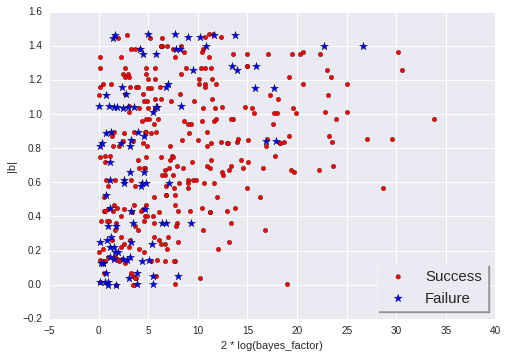

In [16]:
data = np.array(df[['regcoef_true', 'log_bf', 'totalnoise', 'correct_rate']])
ixs1 = np.where(data[:, 3] == 1.0)[0]
ixs2 = np.where(data[:, 3] == 0.0)[0]
plt.scatter(data[ixs1, 1], np.abs(data[ixs1, 0]), marker='o', s=20, c='r', label='Success')
plt.scatter(data[ixs2, 1], np.abs(data[ixs2, 0]), marker='*', s=70, c='b', label='Failure')
plt.ylabel('|b|')
plt.xlabel('2 * log(bayes_factor)')
plt.legend(fontsize=15, loc=4, shadow=True, frameon=True, framealpha=1.0)

## 回帰系数の予測精度
人工データの回帰係数をU(-1.5, 1.5)で生成した実験で, 回帰系数の真値を横軸, 事後分布平均を縦軸に取りプロットしました. 真値が小さい場合は因果方向予測の正解（赤）と不正解（青）に関わらず事後分布平均が小さくなっています. 一方, 正解の場合には回帰係数が小さく, 不正解の場合には回帰係数が小さく推定される傾向があるようです.

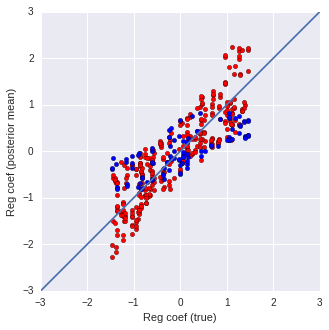

In [17]:
data = np.array(df[['regcoef_true', 'regcoef_est', 'correct_rate']])
ixs1 = np.where(data[:, 2] == 1)[0]
ixs2 = np.where(data[:, 2] == 0)[0]
assert(len(ixs1) + len(ixs2) == len(data))

plt.figure(figsize=(5, 5))
plt.scatter(data[ixs1, 0], data[ixs1, 1], c='r', label='Correct')
plt.scatter(data[ixs2, 0], data[ixs2, 1], c='b', label='Incorrect')
plt.plot([-3, 3], [-3, 3])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect('equal')
plt.xlabel('Reg coef (true)')
plt.ylabel('Reg coef (posterior mean)')

### EPSで出力

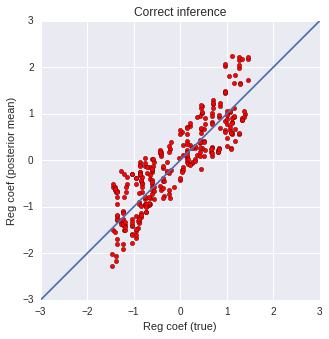

In [18]:
data = np.array(df[['regcoef_true', 'regcoef_est', 'correct_rate']])
ixs1 = np.where(data[:, 2] == 1)[0]
ixs2 = np.where(data[:, 2] == 0)[0]
assert(len(ixs1) + len(ixs2) == len(data))

plt.figure(figsize=(5, 5))
plt.scatter(data[ixs1, 0], data[ixs1, 1], c='r', label='Correct')
plt.plot([-3, 3], [-3, 3])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect('equal')
plt.xlabel('Reg coef (true)')
plt.ylabel('Reg coef (posterior mean)')
plt.title('Correct inference')
plt.savefig('20160905-eval-bml-correct.eps')

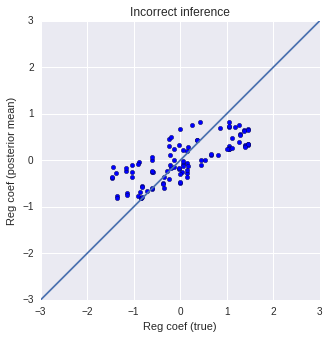

In [19]:
plt.figure(figsize=(5, 5))
plt.scatter(data[ixs2, 0], data[ixs2, 1], c='b', label='Incorrect')
plt.plot([-3, 3], [-3, 3])
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.gca().set_aspect('equal')
plt.xlabel('Reg coef (true)')
plt.ylabel('Reg coef (posterior mean)')
plt.title('Incorrect inference')
plt.savefig('20160905-eval-bml-incorrect.eps')